In [30]:
#----Imports----#
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
import os

In [31]:
#----DTW Function Definitions----#
def euclidean_distance(p: tuple, q: tuple)-> float:
    """
    @description: Computes the euclidean distance between two points
    @param       {tuple} p: (x1, y1)
    @param       {tuple} q: (x2, y2)
    @return      {float} Euclidean distance between p and q
    """
    return np.sqrt((p[0] - q[0])**2 + (p[1] - q[1])**2)

def dtw(seq1: list, seq2: list)-> tuple:
    """
    @description: Computes the DTW distance between two sequences
    @param       {list} seq1: -
    @param       {list} seq2: -
    @return      {tuple} (DTW distance, local errors)
    """
    m, n = len(seq1), len(seq2)
    dtw_matrix = np.full((m+1, n+1), np.inf)
    dtw_matrix[0, 0] = 0

    for i in tqdm(range(1, m+1), desc="Computing DTW", ncols=100):
        for j in range(1, n+1):
            cost = euclidean_distance(seq1[i-1], seq2[j-1])
            dtw_matrix[i, j] = cost + min([dtw_matrix[i-1, j], dtw_matrix[i, j-1], dtw_matrix[i-1, j-1]])
    
    # Extracting the warping path for local errors
    path = []
    i, j = m, n
    while i > 0 or j > 0:
        path.append((i, j))
        min_index = np.argmin([dtw_matrix[i-1, j-1], dtw_matrix[i, j-1], dtw_matrix[i-1, j]])
        if min_index == 0:
            i, j = i-1, j-1
        elif min_index == 1:
            i, j = i, j-1
        else:
            i, j = i-1, j
    path.reverse()
    
    # Computing local errors using the warping path
    local_errors = [euclidean_distance(seq1[i-1], seq2[j-1]) for i, j in path]
    
    return dtw_matrix[m, n], local_errors

In [32]:
#----Data Managing----#
def extract_data_from_file(filename: str)-> list:
    """
    @description: Extracts data from a file
    @param       {str} filename: Name of the file
    @return      {list} List of data points
    """
    data_points = []
    with open(filename, 'r') as file:
        for line in file:
            values = line.split(',')
            x = float(values[1].strip())
            y = float(values[2].strip())
            data_points.append((x, y))
    return data_points

def save_errors_to_file(folders: list, errors: list, local_errors: list)-> None:
    """
    @description: Saves the error data to a file
    @param       {list} folders: list of folders
    @param       {list} errors: dtw distances
    @param       {list} local_errors: local errors
    @return      {*} None
    """
    # Create Errors directory if it doesn't exist
    if not os.path.exists('Errors'):
        os.mkdir('Errors')

    # Save DTW distance
    with open(os.path.join('Errors', f'dtw_distances.txt'), 'w') as f:
        for error in errors:
            f.write(str(error) + '\n')
    # Save DTW distances and local errors
    for idx, folder in enumerate(folders):
        # Save local errors
        with open(os.path.join('Errors', f'local_errors_{folder}.txt'), 'w') as f:
            for local_error in local_errors[idx]:
                f.write(str(local_error) + '\n')

def read_errors_from_file(folders: list) -> (list, list):
    """
    @description: Reads the error data from files
    @param       {list} folders: list of folders from which to read errors
    @return      {tuple}: dtw distances (list) and local errors (list of lists)
    """
    errors = []
    local_errors_list = []

    # Check if Errors directory exists
    if not os.path.exists('Errors'):
        raise ValueError("The 'Errors' directory does not exist.")

    # Read DTW distances
    with open(os.path.join('Errors', 'dtw_distances.txt'), 'r') as f:
        for line in f:
            errors.append(float(line.strip()))

    # Read local errors for each folder
    for folder in folders:
        local_errors = []
        with open(os.path.join('Errors', f'local_errors_{folder}.txt'), 'r') as f:
            for line in f:
                local_errors.append(float(line.strip()))
        local_errors_list.append(local_errors)

    # Trim local errors to the length of the shortest sequence
    min_length = min([len(local_errors) for local_errors in local_errors_list])
    for idx, local_errors in enumerate(local_errors_list):
        local_errors_list[idx] = local_errors[:min_length]

    return errors, local_errors_list


In [33]:
#----Global Variables----#
# FOLDERS = ['1']
FOLDERS = ['3', '6', '8', '9', '10']
RECORD_DATA_CUTOFF = 6000
X_LIM = (-0.5, 4)
Y_LIM = (-2.5, 2)
ERRORS = []
LOCAL_ERRORS = []
RECORD_DATA = []
TEST_DATA = []

In [34]:
# Read and plot record_data.txt as reference
RECORD_DATA = extract_data_from_file('record_data.txt')
RECORD_DATA = RECORD_DATA[:RECORD_DATA_CUTOFF]

# Read test_data.txt from each folder and calculate DTW distance and local errors
for folder in FOLDERS:
    folder_path = os.path.join(folder, 'test_data.txt')
    TEST_DATA.append(extract_data_from_file(folder_path))
    dtw_distance, local_errors = dtw(RECORD_DATA, TEST_DATA[-1])
    ERRORS.append(dtw_distance)
    LOCAL_ERRORS.append(local_errors)
    print(f'DTW distance for {folder_path}: {dtw_distance}')

# Save DTW distances and local errors to files
save_errors_to_file(FOLDERS, ERRORS, LOCAL_ERRORS)

Computing DTW: 100%|███████████████████████████████████████████| 6000/6000 [00:07<00:00, 770.57it/s]


DTW distance for 3/test_data.txt: 507.45016826105825


Computing DTW: 100%|███████████████████████████████████████████| 6000/6000 [00:08<00:00, 713.99it/s]


DTW distance for 6/test_data.txt: 427.95683455300366


Computing DTW: 100%|███████████████████████████████████████████| 6000/6000 [00:07<00:00, 789.08it/s]


DTW distance for 8/test_data.txt: 757.7994292847675


Computing DTW: 100%|███████████████████████████████████████████| 6000/6000 [00:08<00:00, 714.49it/s]


DTW distance for 9/test_data.txt: 545.4828243003137


Computing DTW: 100%|███████████████████████████████████████████| 6000/6000 [00:08<00:00, 701.67it/s]

DTW distance for 10/test_data.txt: 553.208871356301


In [35]:
ERRORS, LOCAL_ERRORS = read_errors_from_file(FOLDERS)

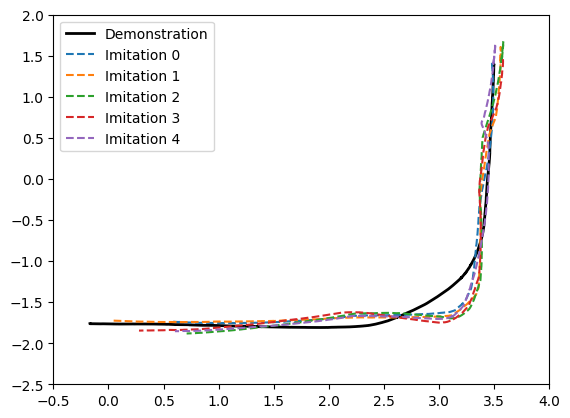

In [36]:
#----Plotting----#
# Plotting trace of record_data.txt and test_data.txt
fig, ax = plt.subplots()
ax.set_xlim(X_LIM)
ax.set_ylim(Y_LIM)
# Plot record_data.txt in red
ax.plot(*zip(*RECORD_DATA), 'k-', label="Demonstration", linewidth=2)
# Plot record_data.txt in green
for idx, folder in enumerate(FOLDERS):
    ax.plot(*zip(*TEST_DATA[idx]), '--',  label=f"Imitation {idx}", linewidth=1.5)
ax.legend()
if not os.path.exists('Figures'):
        os.mkdir('Figures')
plt.savefig('./Figures/Trace.pdf')
plt.show()

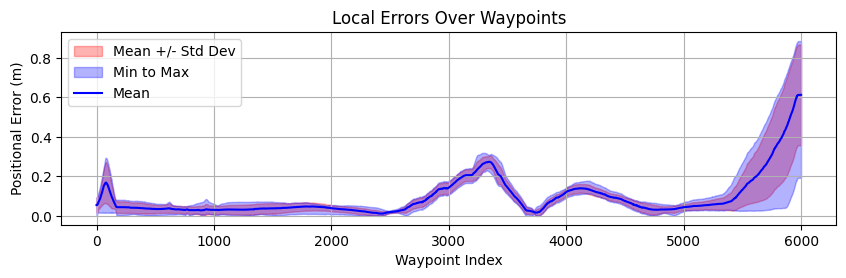

In [37]:
# Plotting local error for all the test datas
# Compute values
max_values = [max(data[i] for data in LOCAL_ERRORS) for i in range(RECORD_DATA_CUTOFF)]
min_values = [min(data[i] for data in LOCAL_ERRORS) for i in range(RECORD_DATA_CUTOFF)]
mean_values = [sum(data[i] for data in LOCAL_ERRORS) / len(FOLDERS) for i in range(RECORD_DATA_CUTOFF)]
std_dev_values = [np.std([data[i] for data in LOCAL_ERRORS]) for i in range(RECORD_DATA_CUTOFF)]

# Plotting
plt.figure(figsize=(10, 2.5))
upper_std = [mean + std for mean, std in zip(mean_values, std_dev_values)]
lower_std = [mean - std for mean, std in zip(mean_values, std_dev_values)]
# Keep lower_std above 0
lower_std = [0 if value < 0 else value for value in lower_std]

plt.fill_between(range(RECORD_DATA_CUTOFF), lower_std, upper_std, color='red', alpha=0.3, label="Mean +/- Std Dev")
plt.fill_between(range(RECORD_DATA_CUTOFF), min_values, max_values, color='blue', alpha=0.3, label="Min to Max")
plt.plot(mean_values, label="Mean", color="blue")

plt.title("Local Errors Over Waypoints")
plt.xlabel("Waypoint Index")
plt.ylabel("Positional Error (m)")
plt.legend()
plt.grid(True)

# Optionally save the figure before showing
if not os.path.exists("Figures"):
    os.mkdir("Figures")
plt.savefig("./Figures/Errors.pdf")
plt.show()